# Tumor region recognition

In [1]:
import spotscope as ss
import scanpy as sc

/nas/ljc/download/miniconda3/envs/spotscope/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import matplotlib.pyplot as plt

device="cuda:1" 
plt.rcParams["figure.figsize"] = (3,3)


adata = sc.read_h5ad("example_data/BRCA/BC24044_E2.h5ad")
type = adata.uns['type']
patient = adata.uns['patient']
rep = adata.uns['replicate']        
color_dict = {
    "Luminal_A": "#64b5cd",         # Orange
    "Luminal_B": "#ccb974",         # Light Peach
    "HER2_luminal": "#55a868",      # Soft Red
    "HER2_non_luminal": "#dd8452",  # Red
    "TNBC": "#c44e52"  ,             # Pale Green
    "Normal": "#8c8c8c",            # Snow (very light pink)
}
adata.var_names_make_unique()

In [ ]:

ss.load_model(
    adata,
    model_path=f"ckpt/brca.pt",
    model=ss.CLIPModel(image_embedding=2048,
                       spot_embedding=6,
                       projection_dim=128),
)
ss.load_query_datasets(adata)

ss.infer(adata=adata, topk=50, device=device, mode='advanced',annotation_type='discrete')
annotations = adata.uns["annotation_list"]
adata.obs["inferred layer"] = annotations[
            adata.obsm["inferred_spot_annotations"].argmax(1)
        ]


/nas/ljc/Spotscope/spotscope/utils.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Finished loading model
Building query loaders
Finished building query loaders
Getting image embeddings...


100%|██████████| 16/16 [00:01<00:00,  8.34it/s]


Getting spot embeddings...
Getting query coordinates...


100%|██████████| 16/16 [00:00<00:00, 39.81it/s]


Querying...


In [4]:
annotations

array(['HER2_luminal', 'HER2_non_luminal', 'Luminal_A', 'Luminal_B',
       'TNBC', 'Normal'], dtype=object)

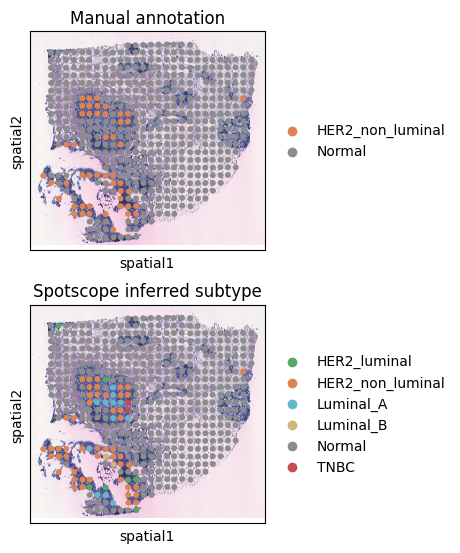

In [5]:
sc.pl.spatial(adata,color=["tumor","inferred layer"], palette=color_dict, title=['Manual annotation','Spotscope inferred subtype',], size=1.5, ncols=1)
plt.show()

In [6]:
adata.obs['ss_2class'] = adata.obs['inferred layer'].map({
    "Luminal_A": "Tumor",         # Orange
    "Luminal_B": "Tumor",         # Light Peach
    "HER2_luminal": "Tumor",      # Soft Red
    "HER2_non_luminal": "Tumor",  # Red
    "TNBC": "Tumor"  ,             # Pale Green
    "Normal": "Normal",            # Snow (very light pink)
})

In [7]:
adata.obs['gt_2class'] = adata.obs['tumor'].map({
    "Luminal_A": "Tumor",         # Orange
    "Luminal_B": "Tumor",         # Light Peach
    "HER2_luminal": "Tumor",      # Soft Red
    "HER2_non_luminal": "Tumor",  # Red
    "TNBC": "Tumor"  ,             # Pale Green
    "Normal": "Normal",            # Snow (very light pink)
})

In [8]:
color_dict['Tumor'] = '#c44e52'

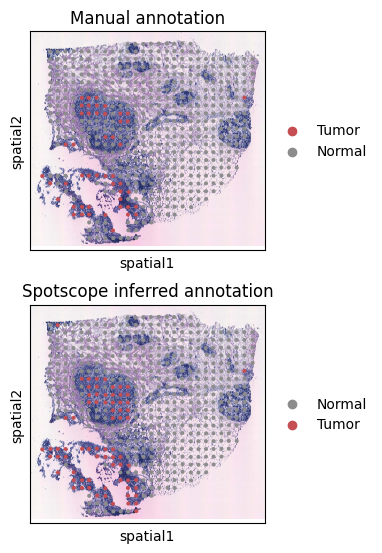

In [9]:
sc.pl.spatial(adata,color=["gt_2class", "ss_2class"], palette=color_dict, show=False, title=['Manual annotation','Spotscope inferred annotation',], ncols=1)
plt.show()

In [10]:
adata_super = ss.super_infer(adata=adata, scale=6, topk=50, device=device, mode='advanced',annotation_type='discrete')

Building query loaders
Finished building query loaders
Getting image embeddings...


100%|██████████| 390/390 [00:22<00:00, 17.13it/s]


Getting query coordinates...


100%|██████████| 390/390 [00:04<00:00, 93.27it/s] 


Querying...


## Super-resolution inference

In [11]:
adata_super

AnnData object with n_obs × n_vars = 12469 × 17570
    uns: 'spatial', 'query_dataloaders', 'query_dataset', 'query_data_size', 'query_img_embeddings', 'reference_spot_embeddings', 'reference_annotations', 'spot_coordinates', 'annotation_list'
    obsm: 'spatial', 'inferred_spot_embeddings', 'inferred_spot_annotations'

In [12]:
adata_super.obs["inferred layer"] = annotations[
            adata_super.obsm["inferred_spot_annotations"].argmax(1)
        ]

[<Axes: title={'center': 'Spotscope inferred subtype'}, xlabel='spatial1', ylabel='spatial2'>]

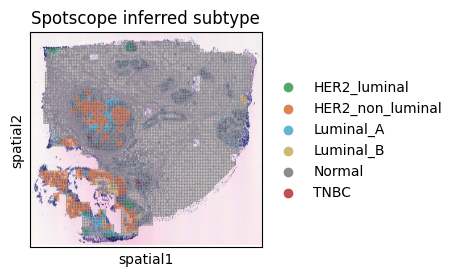

In [13]:
sc.pl.spatial(adata_super, color=['inferred layer'], palette=color_dict, show=False, title='Spotscope inferred subtype', size=1.5)

In [14]:
adata_super.obs['tumor_prob'] = adata_super.obsm["inferred_spot_annotations"][:,:5].sum(1)

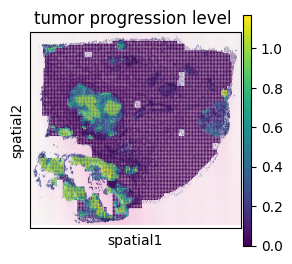

In [15]:
sc.pl.spatial(adata_super, color=['tumor_prob'], title='tumor progression level ', size=1.5)